**Recolectar y describir datos**

Objetivo: cargar los tres datasets (df_Customers, df_Orders, df_OrderItems) y revisar su tamaño, tipos de variables y primeras filas.

In [1]:
import pandas as pd
data_path = "../data/01_raw/"

# Cargar datasets
customers = pd.read_csv(data_path + 'df_Customers.csv')
orders = pd.read_csv(data_path + 'df_Orders.csv')
order_items = pd.read_csv(data_path + 'df_OrderItems.csv')

# Dimensiones
print("Customers:", customers.shape)
print("Orders:", orders.shape)
print("Order Items:", order_items.shape)

# Primeras filas
customers.head()


Customers: (89316, 4)
Orders: (89316, 7)
Order Items: (89316, 5)


,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,hCT0x9JiGXBQ,58125,varzea paulista,SP
1,PxA7fv9spyhx,3112,armacao dos buzios,RJ
2,g3nXeJkGI0Qw,4119,jandira,SP
3,EOEsCQ6QlpIg,18212,uberlandia,MG
4,mVz5LO2Vd6cL,88868,ilhabela,SP


**Análisis exploratorio de datos (EDA)**

1) Estadísticos descriptivos

In [2]:
# Información general
customers.info()
orders.info()
order_items.info()

# Estadísticos numéricos
order_items[["price", "shipping_charges"]].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               89316 non-null  object
 1   customer_zip_code_prefix  89316 non-null  int64 
 2   customer_city             89316 non-null  object
 3   customer_state            89316 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       89316 non-null  object
 1   customer_id                    89316 non-null  object
 2   order_status                   89316 non-null  object
 3   order_purchase_timestamp       89316 non-null  object
 4   order_approved_at              89307 non-null  obje

,price,shipping_charges
count,89316.000000,89316.000000
mean,340.900543,44.283210
std,557.459897,37.672491
min,0.850000,0.000000
25%,59.650000,20.110000
50%,136.900000,35.055000
75%,399.200000,57.190000
max,6735.000000,409.680000


2. Distribución de clientes por localización

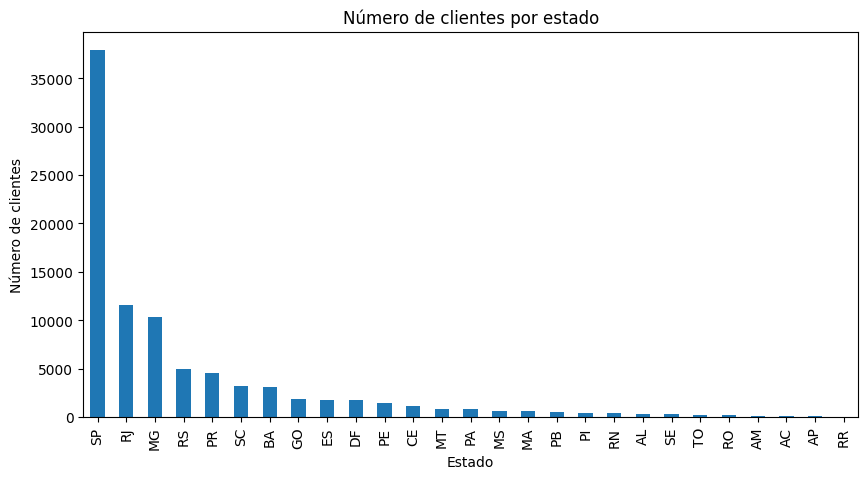

In [3]:
# Visualización de la distribución de clientes por estado
import matplotlib.pyplot as plt

customers["customer_state"].value_counts().plot(kind="bar", figsize=(10,5))
plt.title("Número de clientes por estado")
plt.xlabel("Estado")
plt.ylabel("Número de clientes")
plt.show()


3. Estado de los pedidos

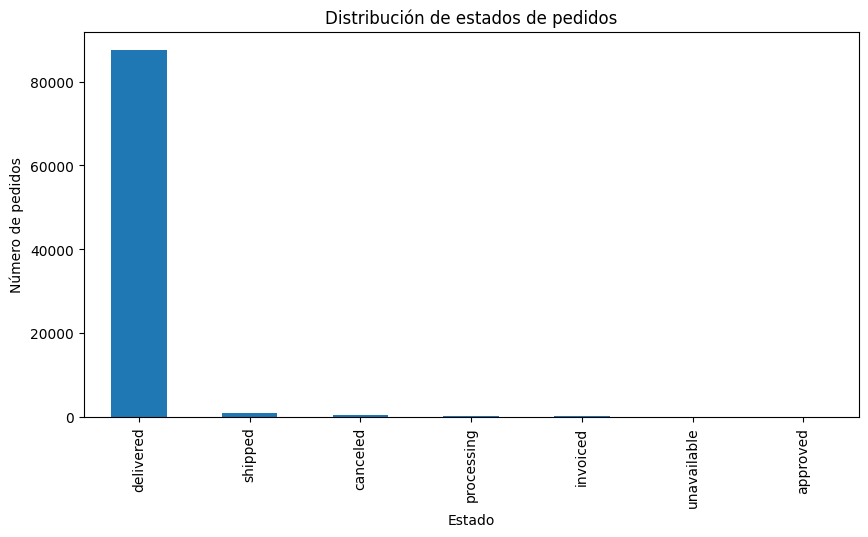

In [4]:
orders["order_status"].value_counts().plot(kind="bar", figsize=(10,5))
plt.title("Distribución de estados de pedidos")
plt.xlabel("Estado")
plt.ylabel("Número de pedidos")
plt.show()

4. Tiempos de entrega

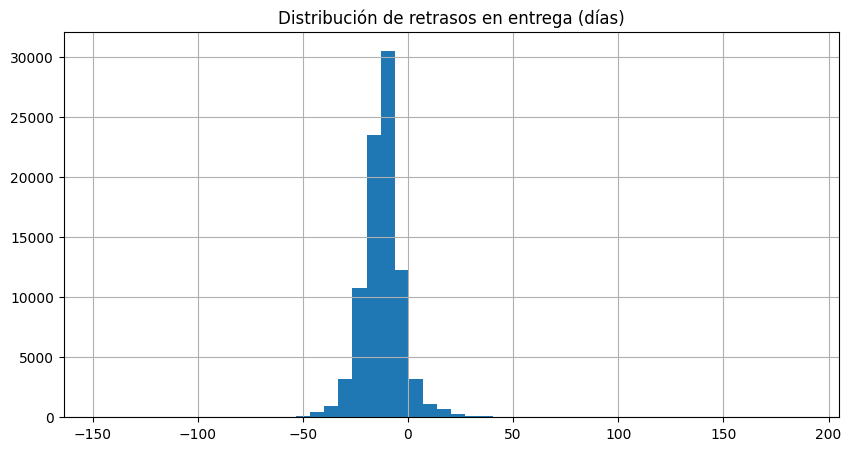

In [5]:
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_delivered_timestamp"] = pd.to_datetime(orders["order_delivered_timestamp"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])

# Retraso en días
orders["delivery_delay"] = (orders["order_delivered_timestamp"] - orders["order_estimated_delivery_date"]).dt.days

orders["delivery_delay"].hist(bins=50, figsize=(10,5))
plt.title("Distribución de retrasos en entrega (días)")
plt.show()


5. Ticket promedio por pedido

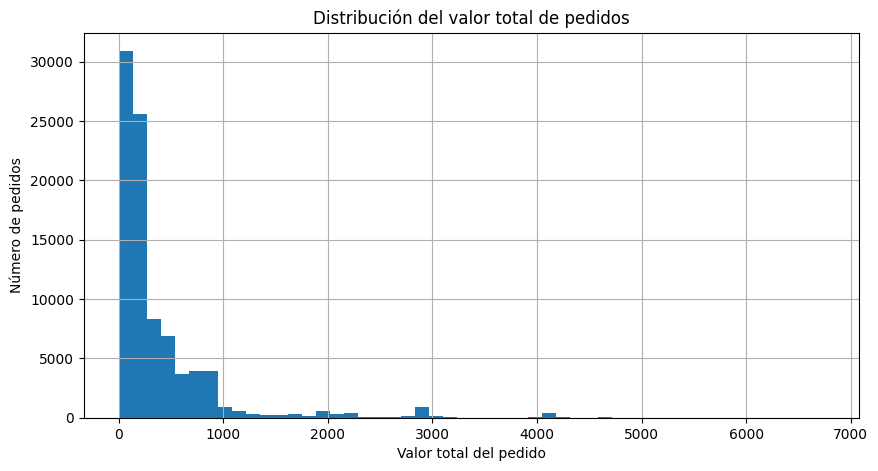

In [6]:
order_items["total_item_value"] = order_items["price"] + order_items["shipping_charges"]

order_value = order_items.groupby("order_id")["total_item_value"].sum()
order_value.hist(bins=50, figsize=(10,5))
plt.title("Distribución del valor total de pedidos")
plt.xlabel("Valor total del pedido")
plt.ylabel("Número de pedidos")
plt.show()


**Revisar calidad de los datos**

Nulos Customers:
 customer_id                 0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
Nulos Orders:
 order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   9
order_delivered_timestamp        1889
order_estimated_delivery_date       0
delivery_delay                   1889
dtype: int64
Nulos OrderItems:
 order_id            0
product_id          0
seller_id           0
price               0
shipping_charges    0
total_item_value    0
dtype: int64
Duplicados Customers: 0
Duplicados Orders: 0
Duplicados OrderItems: 0


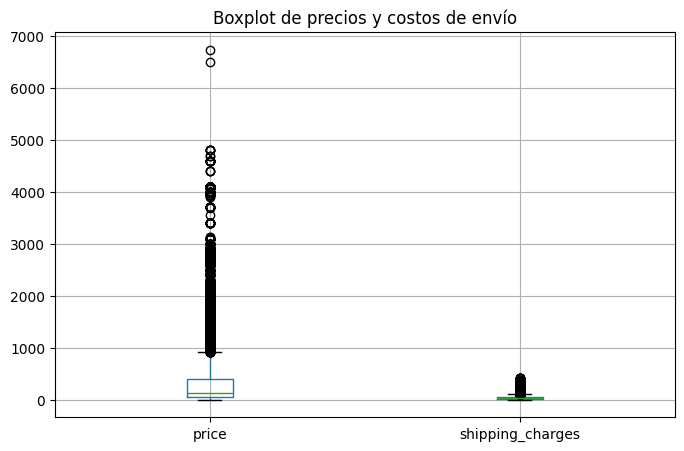

In [7]:
# Valores nulos
print("Nulos Customers:\n", customers.isnull().sum())
print("Nulos Orders:\n", orders.isnull().sum())
print("Nulos OrderItems:\n", order_items.isnull().sum())

# Duplicados
print("Duplicados Customers:", customers.duplicated().sum())
print("Duplicados Orders:", orders.duplicated().sum())
print("Duplicados OrderItems:", order_items.duplicated().sum())

# Outliers en precios y envíos
order_items[["price", "shipping_charges"]].boxplot(figsize=(8,5))
plt.title("Boxplot de precios y costos de envío")
plt.show()


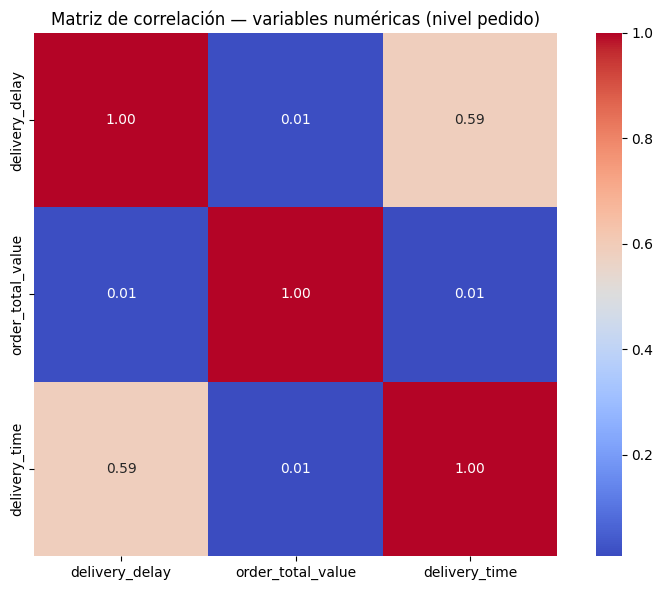

Columnas numéricas usadas para correlación: ['delivery_delay', 'order_total_value', 'delivery_time']


In [8]:
# 6. Matriz de correlación (heatmap)
# Calcula la correlación entre variables numéricas a nivel de pedido y la visualiza.
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarse de tener el valor total por pedido
order_items['total_item_value'] = order_items['price'] + order_items['shipping_charges']
order_value = order_items.groupby('order_id')['total_item_value'].sum().reset_index(name='order_total_value')

# Merge para llevar métricas al nivel pedido
orders_corr = orders.merge(order_value, on='order_id', how='left')

# Derivar delivery_time si no existe
if 'delivery_time' not in orders_corr.columns:
    orders_corr['delivery_time'] = (orders_corr['order_delivered_timestamp'] - orders_corr['order_purchase_timestamp']).dt.days

# Seleccionar columnas numéricas y calcular matriz de correlación
numeric_cols = orders_corr.select_dtypes(include=['number']).columns.tolist()
corr = orders_corr[numeric_cols].corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de correlación — variables numéricas (nivel pedido)')
plt.tight_layout()
plt.show()

# Nota: la correlación se calcula con pares válidos (NaNs se excluyen pairwise). Revisa `numeric_cols` para ver las variables incluidas:
print('Columnas numéricas usadas para correlación:', numeric_cols)

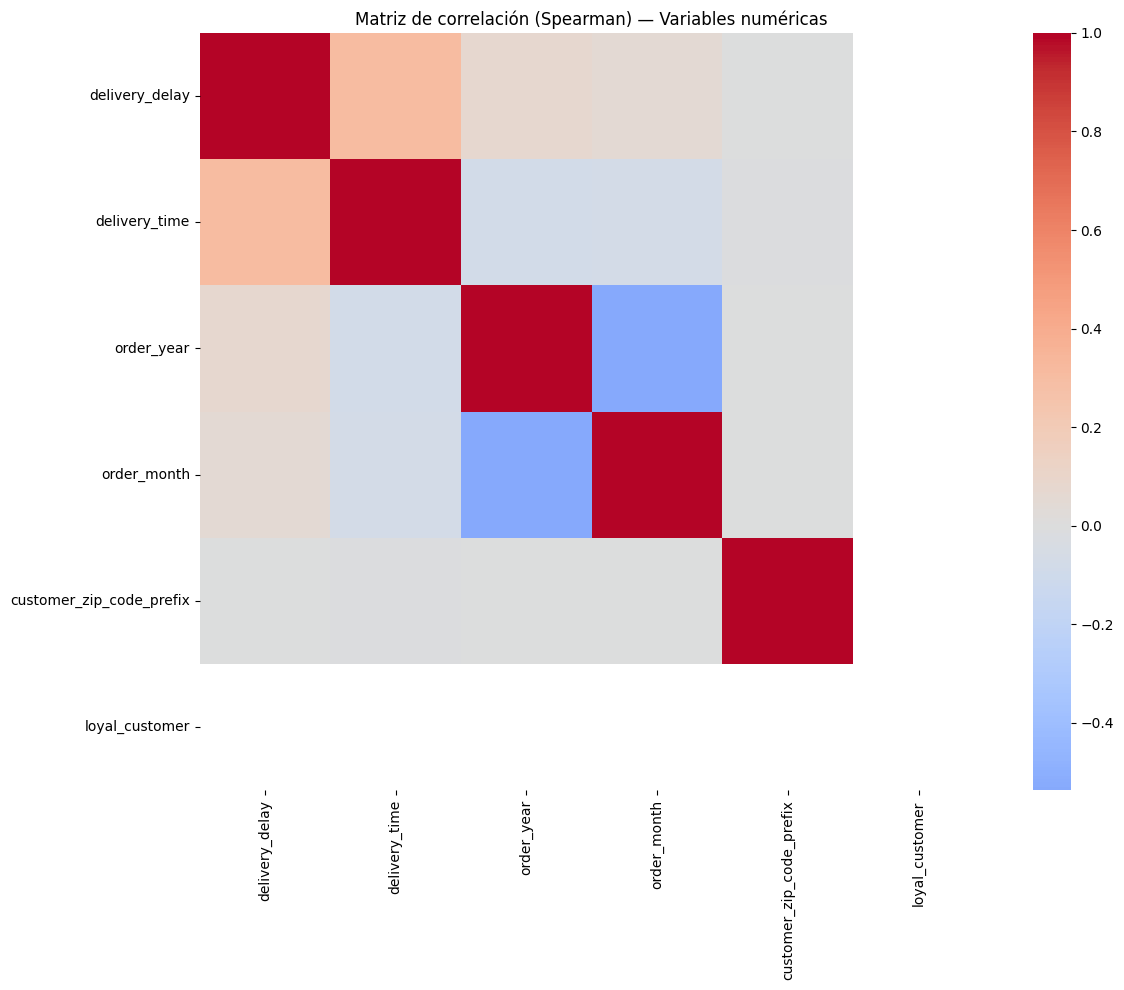

Matriz de correlación guardada en: ..\data\08_reports\correlation_spearman.csv
Heatmap de correlación guardado en: ..\data\08_reports\correlation_spearman.png


In [9]:
# Correlación (Spearman) y VIF (multicolinealidad)
# En esta sección calculamos la matriz de correlación de Spearman para variables numéricas
# y evaluamos la multicolinealidad mediante el VIF. Guardamos resultados en 08_reports.
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Rutas
root = Path('..')
data_path = root / 'data' / '05_model_input' / 'model_input_with_target.csv'
reports_dir = root / 'data' / '08_reports'
reports_dir.mkdir(parents=True, exist_ok=True)

# Cargar datos
_df = pd.read_csv(data_path)

# Seleccionar variables numéricas para correlación
num_cols = _df.select_dtypes(include=['number']).columns.tolist()
if not num_cols:
    raise ValueError('No se encontraron columnas numéricas para la correlación.')

corr_spearman = _df[num_cols].corr(method='spearman')
# Guardar matriz de correlación a CSV
corr_csv_path = reports_dir / 'correlation_spearman.csv'
corr_spearman.to_csv(corr_csv_path, index=True)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, square=False)
plt.title('Matriz de correlación (Spearman) — Variables numéricas')
plt.tight_layout()

corr_png_path = reports_dir / 'correlation_spearman.png'
plt.savefig(corr_png_path, dpi=150)
plt.show()

print(f"Matriz de correlación guardada en: {corr_csv_path}")
print(f"Heatmap de correlación guardado en: {corr_png_path}")

In [10]:
# Análisis de multicolinealidad con VIF
# Nota: requiere el paquete statsmodels. Si no está instalado, ejecute en su entorno: pip install statsmodels
from pathlib import Path
import pandas as pd
import numpy as np

try:
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
except ImportError:
    print("statsmodels no está instalado. Instala con: pip install statsmodels")
    raise

root = Path('..')
data_path = root / 'data' / '05_model_input' / 'model_input_with_target.csv'
reports_dir = root / 'data' / '08_reports'
reports_dir.mkdir(parents=True, exist_ok=True)

_df = pd.read_csv(data_path)
num_cols = _df.select_dtypes(include=['number']).columns.tolist()
if not num_cols:
    raise ValueError('No se encontraron columnas numéricas para VIF.')

X_vif = _df[num_cols].copy()
X_vif = X_vif.fillna(X_vif.median(numeric_only=True))
X_vif_const = sm.add_constant(X_vif, has_constant='add')

vif_values = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]
vif_df = pd.DataFrame({'feature': X_vif_const.columns, 'VIF': vif_values})
vif_df = vif_df[vif_df['feature'] != 'const'].sort_values('VIF', ascending=False).reset_index(drop=True)

vif_csv_path = reports_dir / 'vif_analysis.csv'
vif_df.to_csv(vif_csv_path, index=False)
print('Top 10 VIF:')
print(vif_df.head(10))
print(f"VIF guardado en: {vif_csv_path}")

Top 10 VIF:
                    feature       VIF
0             delivery_time  1.591953
1            delivery_delay  1.591902
2                order_year  1.505754
3               order_month  1.496293
4  customer_zip_code_prefix  1.000215
5            loyal_customer       NaN
VIF guardado en: ..\data\08_reports\vif_analysis.csv


C:\Users\beman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
